The relevant part of the notebook (all but last 2 cells), executes in about 1 minute on a 32GB RAM, i7-10750H CPU.

In [1]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import binom
from scipy.stats import geom
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

In [2]:
def ploter(Ws,S_set): 
    #plots results
    fig,ax = plt.subplots(figsize=(7, 5))
    x = list(range(0, len(Ws[:,0])))
    for i in range(min(len(S_set),5)):
        ax.plot(x, Ws[x,i], label=f"state {S_set[i]}")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Discounted Values')
    # ax.set_ylim([y_low, y_low+1])
    ax.legend(loc="upper left")
    
def latex_table(W_diff,S_set):
    # prints 
    res = np.concatenate(([0],W_diff.cumsum())) 
    res = [[v0-v1 for v1 in res] for v0 in res]
    for i,line in enumerate(res) :
        print(f"$\\sigma'={S_set[i]}$ &",end='')
        for v in line[:-1] :
            print(f'{v:.2f}',end=' & ')
        print(f'{line[-1]:.2f} \\\\')

## Monte Carlo Value iteration

In [3]:
def monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d):
    # Takes a pMDP as input, 
    # Sets the iterator for MCVI
    support_size = len(S_set)*len(R_set)
    P = P_sigma_r_given_sigma.flatten()
    def s_sampler(n_draw):
#         samples n_draws from the distribution P_sigma_r_given_sigma
        X = np.random.choice(np.arange(support_size),n_draw,p=P)
        return (X//len(R_set), R_set[X%len(R_set)])   
    
    def U_of_sample(X,W,n_d):
#         given the sample X, ex-ante state values W, n_d = d(sigma), 
#         returns the expected utility when in state sigma
        c_table = np.array([c(i) for i in range(n_d)]*(X[0].size//n_d))
        return (gamma*W[X[0]] + X[1] - c_table).reshape(-1,n_d).max(1).mean()
    
    def value_iter_MC(gamma, n_sample, report, stop_cond, 
                  seed = 42, decrease_update_rate = True, W_start = 0, start_decrease = 1, reduce_W = 1):
#         Uses gamma as discount rate
#         will sample n_sample s per sigma,
#         report on accuracy every 'report' iteration, 
#         set random seed at seed, 
#         if decrease_update_rate, use accuracy as stop condition, else number of iteration
#         W_start serves to start closer to the game value, makes it easier than to set proper simulation parameters
#         start_decrease allows to start decreasing the update rate only after some iterations have passed
        np.random.seed(seed)
        Ws = np.ones((1,len(S_set)))*W_start
        i = 0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            W_next=np.zeros(len(S_set))
            for i_sigma, sigma in enumerate(S_set):
                n_d = d(sigma)
                n_draw = n_d * n_sample
                W_next[i_sigma] = U_of_sample(s_sampler(n_draw),Ws[-1,:],n_d)
            rate = 1/(i-start_decrease) if decrease_update_rate and i>start_decrease else 1
            Ws = np.concatenate((Ws,(Ws[-1,:]+(W_next-Ws[-1,:])*rate).reshape(1,-1)))
            accuracy = np.max(np.abs(Ws[-1,:]-Ws[-2,:]))
            continue_condition = accuracy > stop_cond if decrease_update_rate else i <= stop_cond
            if i%reduce_W == 0:
                Ws = np.concatenate((Ws[:-reduce_W],Ws[-1,:].reshape(1,-1)))
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        for i_sigma,sigma in enumerate(S_set):
            print(f"state {sigma}, W(sigma) = {Ws[-1,i_sigma]}")
        return Ws
    return value_iter_MC

## Variable change

In [4]:
def variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
    # Takes a pMDP as input, 
    # Sets the iterator for VI with variable change
    def get_U_set_from_W(W,gamma):
        R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
        return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))
    
    def compute_CDF_U_s(W,n_d,U_set,gamma,CDF_U_half=None):
        eps = np.diff(U_set).min()/10 
        if n_d == 1:
            P_U = np.zeros_like(U_set)
            inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
            np.add.at(P_U,inds,P_sigma_r_given_sigma)
            return P_U.cumsum()
        else:
            upsilon = c(n_d//2) - c(0)
#           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
            inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
            return CDF_U_half * CDF_U_half[inds]

    def compute_CDF_U (W,U_set,gamma):
        CDF_U = np.zeros((len(S_set),len(U_set)))
        for i,sigma in enumerate(S_set):
            n_d = d(sigma)
            CDF_U_half = CDF_U[i-1,:] if n_d>1 else None
            CDF_U[i,:] = compute_CDF_U_s (W,n_d,U_set,gamma,CDF_U_half)
        return CDF_U    

    def expected_from_CDF(X,CDF):
        return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

    P = P_sigma_r_given_sigma

    def value_iter_VC(gamma,report, stop_cond, seed = 42, accuracy_stop = True, W_start = 0, reduce_W = 1):
        # will report on accuracy every 'report' iteration, 
        # set random seed at seed, 
        # if accuracy_stop, use accuracy as stop condition, else number of iteration
        np.random.seed(seed)
        Ws = np.ones((1,len(S_set)))*W_start
        i =0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            U_set = get_U_set_from_W(Ws[-1,:],gamma)
            CDF_U = compute_CDF_U(Ws[-1,:],U_set,gamma)
            Ws = np.concatenate((Ws,expected_from_CDF(U_set,CDF_U).reshape(1,-1)))
            accuracy = np.max(np.abs(Ws[-1,:]-Ws[-2,:]))
            continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
            if i%reduce_W == 0:
                Ws = np.concatenate((Ws[:-reduce_W],Ws[-1,:].reshape(1,-1)))
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        for i_sigma,sigma in enumerate(S_set):
            print(f"state {sigma}, W(sigma) = {Ws[-1,i_sigma]}")
        return Ws
    return value_iter_VC

## Variable change - no discount

In [5]:
def variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup):
    # Takes a pMDP as input, 
    # Sets the iterator for VI with variable change with gamma=1
    
    def get_U_set_from_W(W,gamma):
        R_minus_c = np.unique(R_set.reshape(-1,1)- c_sup)
        return np.unique(np.sort((R_minus_c + gamma*W.reshape(-1,1)).flatten()))
    
    def compute_CDF_U_s(W,n_d,U_set,gamma,CDF_U_half=None):
        eps = np.diff(U_set).min()/10
        if n_d == 1:
            P_U = np.zeros_like(U_set)
            inds = np.searchsorted(U_set+eps, R_set-c(0) + gamma*W.reshape(-1,1))
            np.add.at(P_U,inds,P_sigma_r_given_sigma)
            return P_U.cumsum()
        else:
            upsilon = c(n_d//2) - c(0)
#           inds = np.searchsorted(U_set-n_d//2+eps, np.minimum(U_set,U_set[-1]-n_d//2))
            inds = np.searchsorted(U_set+eps, np.minimum(U_set+upsilon,U_set[-1]))
            return CDF_U_half * CDF_U_half[inds]

    def compute_CDF_U (W,U_set,gamma):
        CDF_U = np.zeros((len(S_set),len(U_set)))
        for i,sigma in enumerate(S_set):
            n_d = d(sigma)
            CDF_U_half = CDF_U[i-1,:] if n_d>1 else None
            CDF_U[i,:] = compute_CDF_U_s (W,n_d,U_set,gamma,CDF_U_half)
        return CDF_U    

    def expected_from_CDF(X,CDF):
        return (CDF[:,0]*X[0]) + (np.diff(CDF,axis=1) * X[1:]).sum(1)

    P = P_sigma_r_given_sigma

    def value_iter_VC_ND(report, stop_cond, seed = 42, accuracy_stop = True):
        # will report on accuracy every 'report' iteration, 
        # set random seed at seed, 
        # if accuracy_stop, use accuracy as stop condition, else number of iteration
        np.random.seed(seed)
        Ws_diff = np.zeros((1,len(S_set)-1))
        i = 0
        while i<1 or continue_condition :
            i+=1
            if i%report==0:
                print(f'iteration {i:}, current accuracy is {accuracy}')
            W = np.concatenate(([0], Ws_diff[-1,:])).cumsum()
            U_set = get_U_set_from_W(W,1)
            CDF_U = compute_CDF_U(W,U_set,1)
            W_diff = np.diff(expected_from_CDF(U_set,CDF_U))
            Ws_diff = np.concatenate((Ws_diff,W_diff.reshape(1,-1)))
            accuracy = np.max(np.abs(Ws_diff[-1,:]-Ws_diff[-2,:]))
            continue_condition = accuracy > stop_cond if accuracy_stop else i <= stop_cond
        print("\ndone")
        print(f"iteration {i:}, accuracy {accuracy}")
        for i_sigma,sigma in enumerate(S_set[1:]):
            print(f"state {sigma}, Wdiff(sigma) = {Ws_diff[-1,i_sigma]}")
        return Ws_diff
    return value_iter_VC_ND

## Card Game

In [6]:
# Card game pMDP
S_set = np.array(['club','spade','diamond','heart'])
R_set = np.arange(10)+1

def init_P (S_set = S_set, R_set = R_set):
    P = np.ones((len(S_set),len(R_set)))/4/13
    P[:,-1] *=4
    return P
P_sigma_r_given_sigma = init_P()
def d_setter(s):
    match s:
        case 'club':
            return 1
        case 'spade':
            return 2
        case 'diamond':
            return 4
        case 'heart':
            return 8
        case _:
            print(f"d called without s, input was {s}")

d = d_setter
c = lambda i : 7+i
c_sup = np.arange(8)+7

### Variable change value iteration

In [7]:
# Parameters for the variable change value iteration
gamma = 0.99
accuracy = 1e-4
report = 1e2
W_start = 0
reduce_W = 1

iteration 100, current accuracy is 0.33953945426128485
iteration 200, current accuracy is 0.12428242139789347
iteration 300, current accuracy is 0.04549138568337696
iteration 400, current accuracy is 0.016651318409458327
iteration 500, current accuracy is 0.006094921062697267
iteration 600, current accuracy is 0.002230938226460921
iteration 700, current accuracy is 0.0008165955422754223
iteration 800, current accuracy is 0.0002989003782118971
iteration 900, current accuracy is 0.00010940720524388325

done
iteration 908, accuracy 9.994536900137518e-05
state club, W(sigma) = 89.41268457380367
state spade, W(sigma) = 90.8236362398513
state diamond, W(sigma) = 91.41585312618197
state heart, W(sigma) = 91.47639972180924


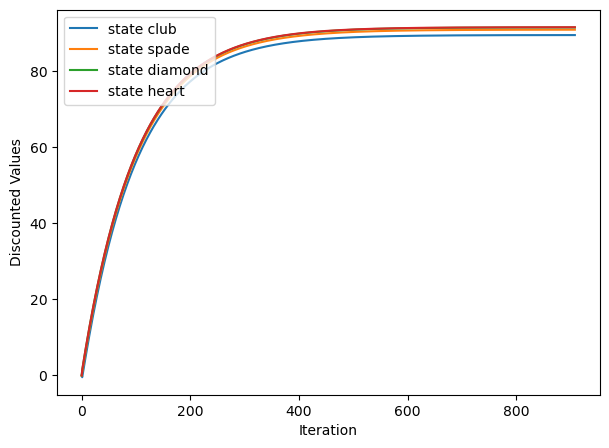

In [8]:
value_iter = variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws=value_iter(gamma,report,accuracy,W_start=W_start,reduce_W = reduce_W )
ploter(Ws,S_set)

### Monte Carlo Value Iteration

In [9]:
# Parameters for Monte Carlo value iteration
gamma = 0.99
accuracy = 1e-4
report = 1e2
W_start = 0
n_sample = int(1e3)
start_decrease = 1e3



iteration 100, current accuracy is 0.458039152566883
iteration 200, current accuracy is 0.17080070682946769
iteration 300, current accuracy is 0.28053957739598445
iteration 400, current accuracy is 0.1663922825105999
iteration 500, current accuracy is 0.1682493592209795
iteration 600, current accuracy is 0.20272610828084225
iteration 700, current accuracy is 0.24018677654727583
iteration 800, current accuracy is 0.10650014165483412
iteration 900, current accuracy is 0.2832544544243518
iteration 1000, current accuracy is 0.1899451183261931
iteration 1100, current accuracy is 0.0011950656738122234
iteration 1200, current accuracy is 0.0004979600568901787
iteration 1300, current accuracy is 0.00014261801565851329

done
iteration 1334, accuracy 7.291202234682714e-05
state club, W(sigma) = 90.14189984429352
state spade, W(sigma) = 91.54985103837934
state diamond, W(sigma) = 92.14400550413771
state heart, W(sigma) = 92.20991013749575


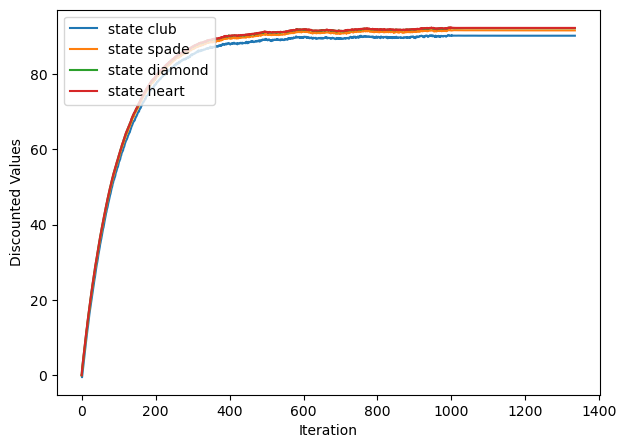

In [10]:
value_iter_MC = monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d)
Ws=value_iter_MC(gamma, n_sample,report,accuracy,W_start=W_start, start_decrease=start_decrease)
ploter(Ws,S_set)

### No Discount Factor

In [11]:
# Parameters for the variable change value iteration
accuracy = 1e-4
report = 1e1


done
iteration 6, accuracy 1.5596833934594656e-05
state spade, Wdiff(sigma) = 1.41304271498828
state diamond, Wdiff(sigma) = 0.5960258483563527
state heart, Wdiff(sigma) = 0.061559091807067645


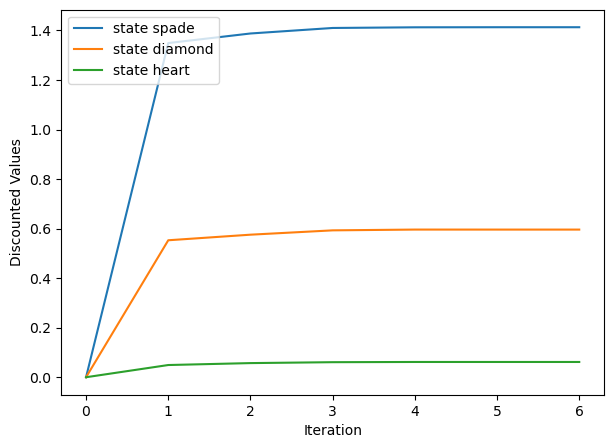

In [12]:
value_iter_VC_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws_diff=value_iter_VC_ND(report, accuracy)
ploter(Ws_diff,S_set[1:])

In [13]:
latex_table(Ws_diff[-1,:],S_set)

$\sigma'=club$ &0.00 & -1.41 & -2.01 & -2.07 \\
$\sigma'=spade$ &1.41 & 0.00 & -0.60 & -0.66 \\
$\sigma'=diamond$ &2.01 & 0.60 & 0.00 & -0.06 \\
$\sigma'=heart$ &2.07 & 0.66 & 0.06 & 0.00 \\


## LRA on RANDAO

In [14]:
# LRA pMDP
n=32
stake = 0.3
S_set = np.arange(n+1)
#A = lambda a : np.arange(a)
R_set = np.arange(n+1)

def init_P (S_set = S_set, R_set = R_set,stake=stake):
    P = np.zeros((n+1,n+1))
    for s in range(n):
        for r in range(s,n):
            P[s,r] = geom.pmf(s+1,1-stake) * binom.pmf(r-s,n-s-1,stake)
    P[n,n] = geom.sf(n,1-stake)
    return P

P_sigma_r_given_sigma = init_P()
d = lambda s:int(2**s)
c = lambda i : bin(i).count("1")
c_sup = np.arange(n+1)

### Variable change value iteration

In [15]:
# Parameters for the variable change value iteration
gamma = 0.999
accuracy = 1e-5
report = 1e3
W_start = 10060
reduce_W = int(1e0)

iteration 1000, current accuracy is 0.0016542157809453784
iteration 2000, current accuracy is 0.000608247575655696
iteration 3000, current accuracy is 0.0002236498512502294
iteration 4000, current accuracy is 8.223503209592309e-05
iteration 5000, current accuracy is 3.0237446480896324e-05
iteration 6000, current accuracy is 1.1118172551505268e-05

done
iteration 6105, accuracy 9.999428584706038e-06
state 0, W(sigma) = 10063.9335086228
state 1, W(sigma) = 10065.090948647847
state 2, W(sigma) = 10066.057702003483
state 3, W(sigma) = 10066.881163034315
state 4, W(sigma) = 10067.598085860958
state 5, W(sigma) = 10068.23506605651
state 6, W(sigma) = 10068.810831011673
state 7, W(sigma) = 10069.338470420771
state 8, W(sigma) = 10069.827190378568
state 9, W(sigma) = 10070.28358200385
state 10, W(sigma) = 10070.712502075034
state 11, W(sigma) = 10071.117635791701
state 12, W(sigma) = 10071.501912225782
state 13, W(sigma) = 10071.867675133986
state 14, W(sigma) = 10072.21690701473
state 15, W(s

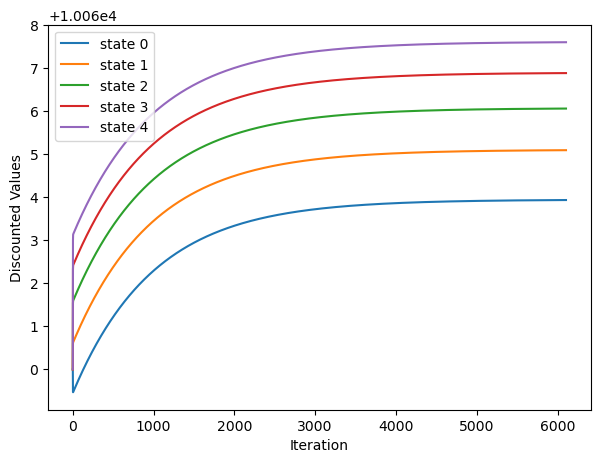

In [16]:
value_iter = variable_change_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws=value_iter(gamma,report,accuracy,W_start=W_start, reduce_W = reduce_W)
ploter(Ws,S_set)

### No Discount Factor

In [17]:
# Parameters for the variable change value iteration
accuracy = 1e-5
report = 1e2


done
iteration 10, accuracy 2.223099972553655e-06
state 1, Wdiff(sigma) = 1.157701938255979
state 2, Wdiff(sigma) = 0.9670503481393862
state 3, Wdiff(sigma) = 0.8237777153347388
state 4, Wdiff(sigma) = 0.7172503396315317
state 5, Wdiff(sigma) = 0.6373164566677474
state 6, Wdiff(sigma) = 0.5761109244048956
state 7, Wdiff(sigma) = 0.5279955294099761
state 8, Wdiff(sigma) = 0.4890846619808613
state 9, Wdiff(sigma) = 0.4567615895716557
state 10, Wdiff(sigma) = 0.42929128298298735
state 11, Wdiff(sigma) = 0.40550259455554993
state 12, Wdiff(sigma) = 0.3846404650054822
state 13, Wdiff(sigma) = 0.3661206375094608
state 14, Wdiff(sigma) = 0.34958333058020585
state 15, Wdiff(sigma) = 0.3347043631022828
state 16, Wdiff(sigma) = 0.32122060977451383
state 17, Wdiff(sigma) = 0.3090053843335845
state 18, Wdiff(sigma) = 0.2978078165926199
state 19, Wdiff(sigma) = 0.28755707897901317
state 20, Wdiff(sigma) = 0.27813848777552863
state 21, Wdiff(sigma) = 0.26939898920564076
state 22, Wdiff(sigma) = 0.2

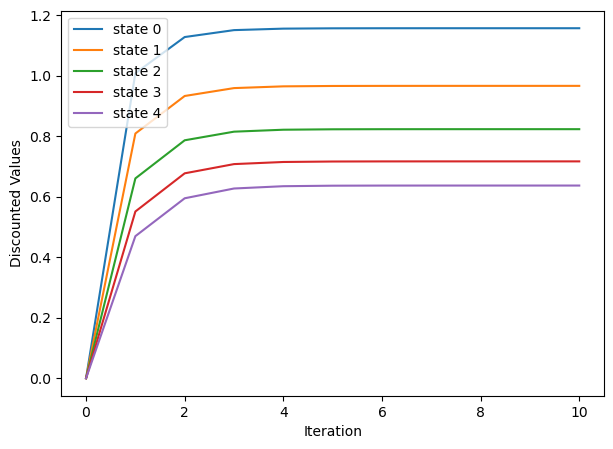

In [18]:
value_iter_ND = variable_change_ND_setter(P_sigma_r_given_sigma,S_set,R_set,c,d,c_sup)
Ws_diff=value_iter_ND(report,accuracy)
ploter(Ws_diff,S_set)

In [19]:
latex_table(Ws_diff[-1,:4],S_set)

$\sigma'=0$ &0.00 & -1.16 & -2.12 & -2.95 & -3.67 \\
$\sigma'=1$ &1.16 & 0.00 & -0.97 & -1.79 & -2.51 \\
$\sigma'=2$ &2.12 & 0.97 & 0.00 & -0.82 & -1.54 \\
$\sigma'=3$ &2.95 & 1.79 & 0.82 & 0.00 & -0.72 \\
$\sigma'=4$ &3.67 & 2.51 & 1.54 & 0.72 & 0.00 \\


### Monte Carlo Value Iteration (Does not run because of complexity)

This part does not run as sampling $s$ is too hard for high ex-ante states...
For the last one : $\sigma=32$, we have $d(\sigma)=2^{32}$. Making the sampling of $s$ too complicated and preventing iterations   

In [20]:
# Parameters for Monte Carlo value iteration
gamma = 0.99
accuracy = 1e-3
report = 2
W_start = 1020
n_sample = int(1e0)
start_decrease = 1e1



In [ ]:
# will not compute : when sigma = 32, cannot sample s of size 2**32
value_iter_MC = monte_carlo_setter(P_sigma_r_given_sigma,S_set,R_set,c,d)
Ws=value_iter_MC(gamma, n_sample,report,accuracy,W_start=W_start, start_decrease=start_decrease)
ploter(Ws,S_set)